# 単純支持の片持ち梁での検討

GetFEM++を使用して単純支持の片持ち梁に荷重を与え、理論解との比較をします。

In [1]:
import os
import sys
sys.path.append('../getfem/interface/src/python/')
import getfem as gf
import numpy as np

検討するケースは次の通りです。GetFEM++において下に示す有限要素法と積分をそれぞれFEM_PRODUCTとIM_PRDOCTを使用して2次元化して使用します。2次要素についてはガウスの積分点が3として解析を行います。IM_GAUSS1D(K)はK/2+1点のガウス積分を表します。

| ケース名 | 要素定式化       | 分割    | 有限要素法                     | 積分            | 要素            |
| -------- | ---------------- | ------- | ------------------------------ | --------------- | --------------- |
| case11   | 2次要素          | 1×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case12   | 2次要素          | 2×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case13   | 2次要素          | 4×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case14   | 2次要素          | 8×16   | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case21   | 1次完全積分要素  | 1×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   | 平面ひずみ要素  |
| case22   | 1次完全積分要素  | 2×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   | 平面ひずみ要素  |
| case23   | 1次完全積分要素  | 4×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   | 平面ひずみ要素  |
| case24   | 1次完全積分要素  | 8×16   | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   | 平面ひずみ要素  |
| case31   | 1次低減積分要素  | 1×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   | 平面ひずみ要素  |
| case32   | 1次低減積分要素  | 2×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   | 平面ひずみ要素  |
| case33   | 1次低減積分要素  | 4×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   | 平面ひずみ要素  |
| case34   | 1次低減積分要素  | 8×16   | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   | 平面ひずみ要素  |
| case41   | 1次非適合要素    | 1×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case42   | 1次非適合要素    | 2×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case43   | 1次非適合要素    | 4×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   | 平面ひずみ要素  |
| case44   | 1次非適合要素    | 8×16   | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   | 平面ひずみ要素  |

それでは、これらの有限要素法と積分法をそれぞれ設定します。メッシュを最初に設定します。モデル全体のサイズはX方向にL = 8、Y方向にh = 1とします。一般的に細長比（スレンダー比）が1:10であれば梁とみなせると言われています。(http://femingway.com/?p=1310)

In [2]:
L = 8.0
h = 1.0

x01 = np.arange(1+1)*1/1
x04 = np.arange(4+1)*L/4
x16 = np.arange(16+1)*L/16

y01 = np.arange(1+1)*h/1
y02 = np.arange(2+1)*h/2
y04 = np.arange(4+1)*h/4
y08 = np.arange(8+1)*h/8

m11 = gf.Mesh('cartesian', x04, y01)
m12 = gf.Mesh('cartesian', x04, y02)
m13 = gf.Mesh('cartesian', x04, y04)
m14 = gf.Mesh('cartesian', x16, y08)
m21 = gf.Mesh('cartesian', x04, y01)
m22 = gf.Mesh('cartesian', x04, y02)
m23 = gf.Mesh('cartesian', x04, y04)
m24 = gf.Mesh('cartesian', x16, y08)
m31 = gf.Mesh('cartesian', x04, y01)
m32 = gf.Mesh('cartesian', x04, y02)
m33 = gf.Mesh('cartesian', x04, y04)
m34 = gf.Mesh('cartesian', x16, y08)
m41 = gf.Mesh('cartesian', x04, y01)
m42 = gf.Mesh('cartesian', x04, y02)
m43 = gf.Mesh('cartesian', x04, y04)
m44 = gf.Mesh('cartesian', x16, y08)

ms = [m11, m12, m13, m14, m21, m22, m23, m24, m31, m32, m33, m34, m41, m42, m43, m44]

m11.export_to_vtk('m11.vtk')
m12.export_to_vtk('m12.vtk')
m13.export_to_vtk('m13.vtk')
m14.export_to_vtk('m14.vtk')

In [3]:
def plot_vtk(filename, picturename):
    from mayavi import mlab
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(filename)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    surface = mlab.pipeline.surface(extract_edges)
    axes = mlab.axes(surface)
    
    mlab.show()
    mlab.savefig(picturename)
    mlab.clf()
    from IPython.display import Image, display_png
    display_png(Image(picturename))

1×4のメッシュを表示します。

Notebook initialized with ipy backend.


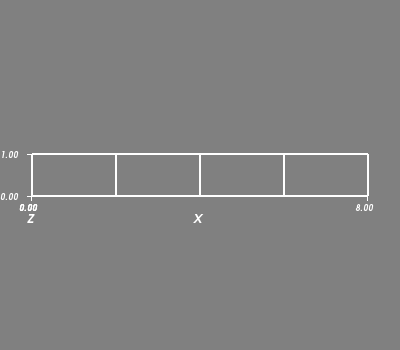

In [4]:
plot_vtk(filename = 'm11.vtk', picturename = 'm0101.png')

2×4のメッシュを表示します。

Notebook initialized with ipy backend.


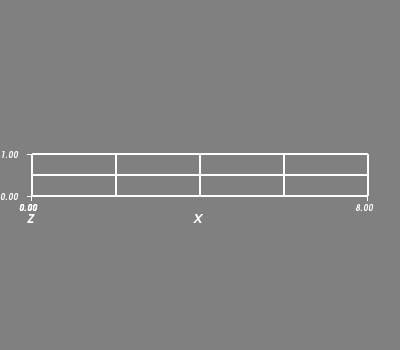

In [5]:
plot_vtk(filename = 'm12.vtk', picturename = 'm0104.png')

4×4のメッシュを表示します。

Notebook initialized with ipy backend.


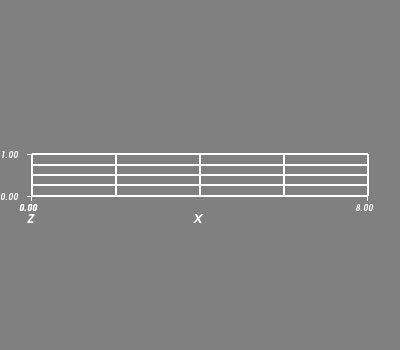

In [6]:
plot_vtk(filename = 'm13.vtk', picturename = 'm0204.png')

8×16のメッシュを表示します。

Notebook initialized with ipy backend.


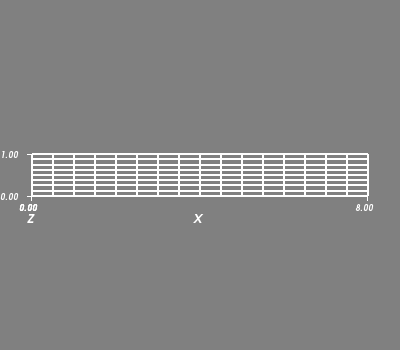

In [7]:
plot_vtk(filename = 'm14.vtk', picturename = 'm0816.png')

各メッシュの左側面にDirichlet条件を設定するための境界領域を設定します。各メッシュの右側面にNeumann条件を設定するための境界領域を設定します。

In [8]:
right = 1
left = 2

for m in ms:

    flst = m.outer_faces()
    fnor = m.normal_of_faces(flst)

    tright = abs(fnor[0, :] - 1) < 1e-14
    tleft = abs(fnor[0, :] + 1) < 1e-14

    fright = np.compress(tright, flst, axis=1)
    fleft = np.compress(tleft, flst, axis=1)

    m.set_region(right, fright)
    m.set_region(left, fleft)

MeshFEMオブジェクトを作成し各メッシュと有限要素法を関連付けます。

In [9]:
mfu11 = gf.MeshFem(m11, 2)
mfu12 = gf.MeshFem(m12, 2)
mfu13 = gf.MeshFem(m13, 2)
mfu14 = gf.MeshFem(m14, 2)
mfu21 = gf.MeshFem(m21, 2)
mfu22 = gf.MeshFem(m22, 2)
mfu23 = gf.MeshFem(m23, 2)
mfu24 = gf.MeshFem(m24, 2)
mfu31 = gf.MeshFem(m31, 2)
mfu32 = gf.MeshFem(m32, 2)
mfu33 = gf.MeshFem(m33, 2)
mfu34 = gf.MeshFem(m34, 2)
mfu41 = gf.MeshFem(m41, 2)
mfu42 = gf.MeshFem(m42, 2)
mfu43 = gf.MeshFem(m43, 2)
mfu44 = gf.MeshFem(m44, 2)

mfus = [mfu11, mfu12, mfu13, mfu14, mfu21, mfu22, mfu23, mfu24, mfu31, mfu32, mfu33, mfu34, mfu41, mfu42, mfu43, mfu44]

fem11 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))') # 2次要素
fem12 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))') # 2次要素
fem13 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))') # 2次要素
fem14 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))') # 2次要素
fem21 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem22 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem23 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem24 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem31 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem32 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem33 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem34 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem41 = gf.Fem('FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))') # 非適合要素
fem42 = gf.Fem('FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))') # 非適合要素
fem43 = gf.Fem('FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))') # 非適合要素
fem44 = gf.Fem('FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))') # 非適合要素

fems = [fem11, fem12, fem13, fem14, fem21, fem22, fem23, fem24, fem31, fem32, fem33, fem34, fem41, fem42, fem43, fem44]

for mfu, fem in zip(mfus, fems):
    mfu.set_fem(fem)

積分法を定義します。

In [10]:
inm11 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 2次完全積分
inm12 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 2次完全積分
inm13 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 2次完全積分
inm14 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 2次完全積分
inm21 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))') # 1次完全積分
inm22 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))') # 1次完全積分
inm23 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))') # 1次完全積分
inm24 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))') # 1次完全積分
inm31 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))') # 1次低減積分
inm32 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))') # 1次低減積分
inm33 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))') # 1次低減積分
inm34 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))') # 1次低減積分
inm41 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 非適合要素完全積分
inm42 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 非適合要素完全積分
inm43 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 非適合要素完全積分
inm44 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 非適合要素完全積分

In [11]:
mim11 = gf.MeshIm(m11, inm11)
mim12 = gf.MeshIm(m12, inm12)
mim13 = gf.MeshIm(m13, inm13)
mim14 = gf.MeshIm(m14, inm14)
mim21 = gf.MeshIm(m21, inm21)
mim22 = gf.MeshIm(m22, inm22)
mim23 = gf.MeshIm(m23, inm23)
mim24 = gf.MeshIm(m24, inm24)
mim31 = gf.MeshIm(m31, inm31)
mim32 = gf.MeshIm(m32, inm32)
mim33 = gf.MeshIm(m33, inm33)
mim34 = gf.MeshIm(m34, inm34)
mim41 = gf.MeshIm(m41, inm41)
mim42 = gf.MeshIm(m42, inm42)
mim43 = gf.MeshIm(m43, inm43)
mim44 = gf.MeshIm(m44, inm44)

mims = [mim11, mim12, mim13, mim14, mim21, mim22, mim23, mim24, mim31, mim32, mim33, mim34, mim41, mim42, mim43, mim44]

モデルを定義し、各ケースの変数を追加します。

In [12]:
md11 = gf.Model('real')
md12 = gf.Model('real')
md13 = gf.Model('real')
md14 = gf.Model('real')
md21 = gf.Model('real')
md22 = gf.Model('real')
md23 = gf.Model('real')
md24 = gf.Model('real')
md31 = gf.Model('real')
md32 = gf.Model('real')
md33 = gf.Model('real')
md34 = gf.Model('real')
md41 = gf.Model('real')
md42 = gf.Model('real')
md43 = gf.Model('real')
md44 = gf.Model('real')

mds = [md11, md12, md13, md14, md21, md22, md23, md24, md31, md32, md33, md34, md41, md42, md43, md44]

for md, mfu in zip(mds, mfus):
    md.add_fem_variable('u', mfu)

各変位に対し剛性行列を追加します。ヤング率を$E = 1.0 \times 10^3$ポアソン比を$\nu = 0.3$とします。

In [13]:
E = 1e3
Nu = 0.3

for md, mim in zip(mds, mims):
    md.add_initialized_data('E', E)
    md.add_initialized_data('Nu', Nu)

平面歪要素を定義します。

In [14]:
for md, mim in zip(mds, mims):
    md.add_isotropic_linearized_elasticity_brick_pstrain(mim, 'u', 'E', 'Nu')

各変数について、左側面にDirichlet境界条件を設定します。

In [15]:
md11.add_Dirichlet_condition_with_simplification('u', left)
md12.add_Dirichlet_condition_with_simplification('u', left)
md13.add_Dirichlet_condition_with_simplification('u', left)
md14.add_Dirichlet_condition_with_simplification('u', left)
md21.add_Dirichlet_condition_with_simplification('u', left)
md22.add_Dirichlet_condition_with_simplification('u', left)
md23.add_Dirichlet_condition_with_simplification('u', left)
md24.add_Dirichlet_condition_with_simplification('u', left)
md31.add_Dirichlet_condition_with_simplification('u', left)
md32.add_Dirichlet_condition_with_simplification('u', left)
md33.add_Dirichlet_condition_with_simplification('u', left)
md34.add_Dirichlet_condition_with_simplification('u', left)
md41.add_Dirichlet_condition_with_multipliers(mim41, 'u', mfu41, left)
md42.add_Dirichlet_condition_with_multipliers(mim42, 'u', mfu42, left)
md43.add_Dirichlet_condition_with_multipliers(mim43, 'u', mfu43, left)
md44.add_Dirichlet_condition_with_multipliers(mim44, 'u', mfu44, left)
# for md, mim, mfu in zip(mds, mims, mfus):
#     if mfu.is_lagrangian:
#         md.add_Dirichlet_condition_with_simplification('u', left)
#     else:
#         md.add_Dirichlet_condition_with_multipliers(mim, 'u', mfu, left)

1

各変数について、右側面にNeumann境界条件を設定します。

In [16]:
F = 1.0

for md, mfu in zip(mds, mfus):
    md.add_fem_data('F', mfu)
    Fs = np.zeros(mfu.nbdof())
    Fs[1::2] = F
    md.set_variable('F', Fs)

In [17]:
for md, mim in zip(mds, mims):
    md.add_source_term_brick(mim, 'u', 'F', right)

各変数に対して構築したためモデルmdを解きます。

In [18]:
for md in mds:
    md.solve()

In [19]:
u11 = md11.variable('u')
u12 = md12.variable('u')
u13 = md13.variable('u')
u14 = md14.variable('u')
u21 = md21.variable('u')
u22 = md22.variable('u')
u23 = md23.variable('u')
u24 = md24.variable('u')
u31 = md31.variable('u')
u32 = md32.variable('u')
u33 = md33.variable('u')
u34 = md34.variable('u')
u41 = md41.variable('u')
u42 = md42.variable('u')
u43 = md43.variable('u')
u44 = md44.variable('u')

In [20]:
mfu11.export_to_vtk('u11.vtk', 'ascii', mfu11, u11, 'u11')
mfu12.export_to_vtk('u12.vtk', 'ascii', mfu12, u12, 'u12')
mfu13.export_to_vtk('u13.vtk', 'ascii', mfu13, u13, 'u13')
mfu14.export_to_vtk('u14.vtk', 'ascii', mfu14, u14, 'u14')
mfu21.export_to_vtk('u21.vtk', 'ascii', mfu21, u21, 'u21')
mfu22.export_to_vtk('u22.vtk', 'ascii', mfu22, u22, 'u22')
mfu23.export_to_vtk('u23.vtk', 'ascii', mfu23, u23, 'u23')
mfu24.export_to_vtk('u24.vtk', 'ascii', mfu24, u24, 'u24')
mfu31.export_to_vtk('u31.vtk', 'ascii', mfu31, u31, 'u31')
mfu32.export_to_vtk('u32.vtk', 'ascii', mfu32, u32, 'u32')
mfu33.export_to_vtk('u33.vtk', 'ascii', mfu33, u33, 'u33')
mfu34.export_to_vtk('u34.vtk', 'ascii', mfu34, u34, 'u34')
mfu41.export_to_vtk('u41.vtk', 'ascii', mfu41, u41, 'u41')
mfu42.export_to_vtk('u42.vtk', 'ascii', mfu42, u42, 'u42')
mfu43.export_to_vtk('u43.vtk', 'ascii', mfu43, u43, 'u43')
mfu44.export_to_vtk('u44.vtk', 'ascii', mfu44, u44, 'u44')

In [21]:
def plot_vtk2(filename, picturename):
    from mayavi import mlab
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(filename)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    warp_vector = mlab.pipeline.warp_vector(extract_edges)
    surface = mlab.pipeline.surface(warp_vector)
    axes = mlab.axes(surface)

    mlab.show()
    mlab.savefig(picturename)
    mlab.clf()
    from IPython.display import Image, display_png
    display_png(Image(picturename))

各出力をプロットします。

Notebook initialized with ipy backend.


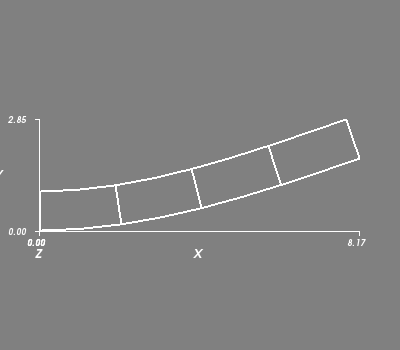

In [22]:
plot_vtk2('u11.vtk', 'u11.png')

Notebook initialized with ipy backend.


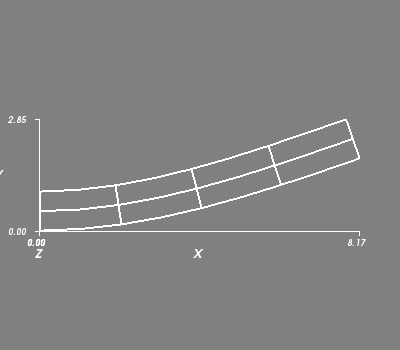

In [23]:
plot_vtk2('u12.vtk', 'u12.png')

Notebook initialized with ipy backend.


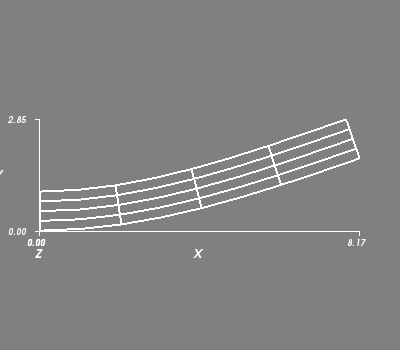

In [24]:
plot_vtk2('u13.vtk', 'u13.png')

Notebook initialized with ipy backend.


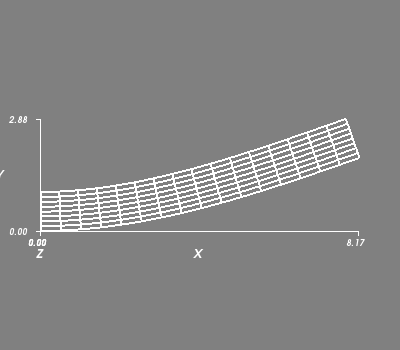

In [25]:
plot_vtk2('u14.vtk', 'u14.png')

Notebook initialized with ipy backend.


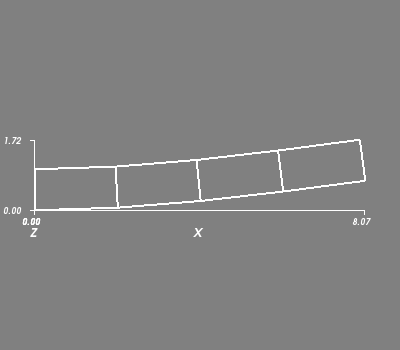

In [26]:
plot_vtk2('u21.vtk', 'u21.png')

Notebook initialized with ipy backend.


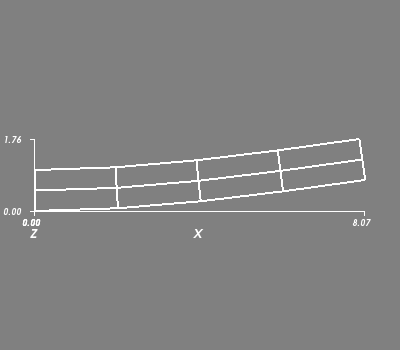

In [27]:
plot_vtk2('u22.vtk', 'u22.png')

Notebook initialized with ipy backend.


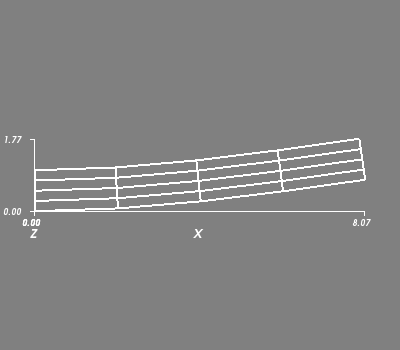

In [28]:
plot_vtk2('u23.vtk', 'u23.png')

Notebook initialized with ipy backend.


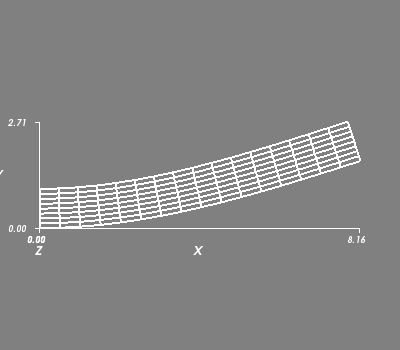

In [29]:
plot_vtk2('u24.vtk', 'u24.png')

case31の結果は発散をしています。

Notebook initialized with ipy backend.


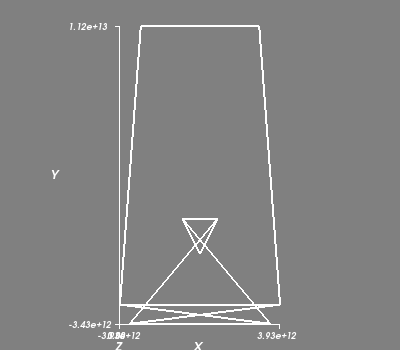

In [30]:
plot_vtk2('u31.vtk', 'u31.png')

Notebook initialized with ipy backend.


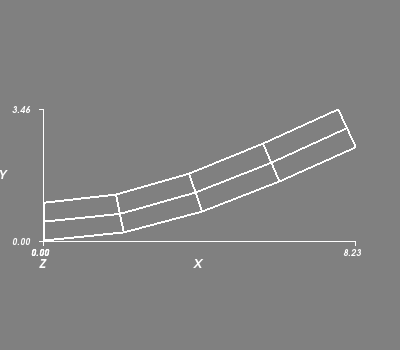

In [31]:
plot_vtk2('u32.vtk', 'u32.png')

Notebook initialized with ipy backend.


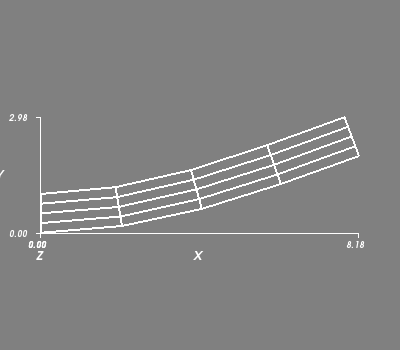

In [32]:
plot_vtk2('u33.vtk', 'u33.png')

Notebook initialized with ipy backend.


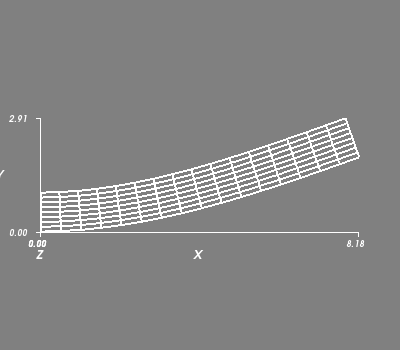

In [33]:
plot_vtk2('u34.vtk', 'u34.png')

Notebook initialized with ipy backend.


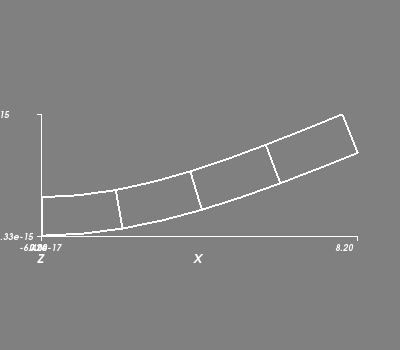

In [34]:
plot_vtk2('u41.vtk', 'u41.png')

Notebook initialized with ipy backend.


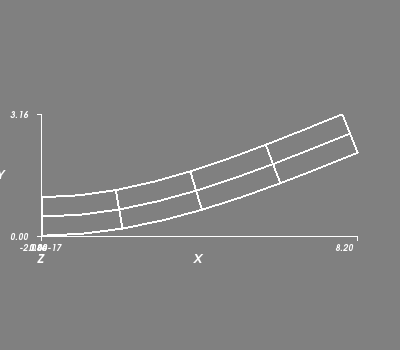

In [35]:
plot_vtk2('u42.vtk', 'u42.png')

Notebook initialized with ipy backend.


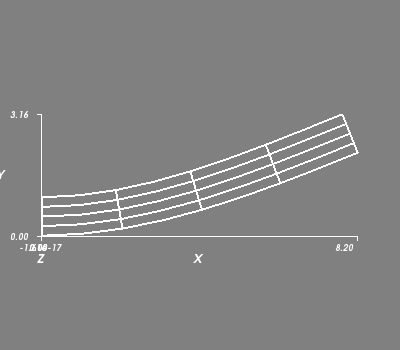

In [36]:
plot_vtk2('u43.vtk', 'u43.png')

Notebook initialized with ipy backend.


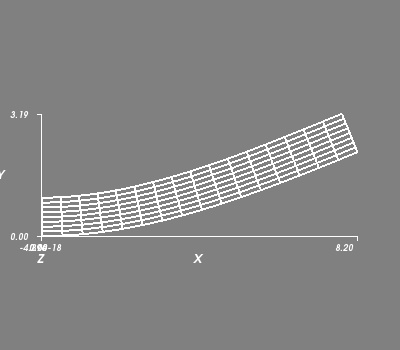

In [37]:
plot_vtk2('u44.vtk', 'u44.png')

理論式との比較を行います。片持はりの先端のたわみ理論式は
$$\delta = \dfrac{1}{3}\dfrac{FL^{3}}{EI} $$
計算をすると次のようになります。

In [38]:
b = 1.0
I = b*h**3.0/12.0
dmax = 1.0/3.0*(F*L**3)/(E*I)
dmax

2.048

理論解と解析結果の比較をすると次のようになります。

In [39]:
print("max(u11)/dmax = {0}".format(round(max(u11[1::2])/dmax, 3)))
print("max(u12)/dmax = {0}".format(round(max(u12[1::2])/dmax, 3)))
print("max(u13)/dmax = {0}".format(round(max(u13[1::2])/dmax, 3)))
print("max(u14)/dmax = {0}".format(round(max(u14[1::2])/dmax, 3)))
print("max(u21)/dmax = {0}".format(round(max(u21[1::2])/dmax, 3)))
print("max(u22)/dmax = {0}".format(round(max(u22[1::2])/dmax, 3)))
print("max(u23)/dmax = {0}".format(round(max(u23[1::2])/dmax, 3)))
print("max(u24)/dmax = {0}".format(round(max(u24[1::2])/dmax, 3)))
print("max(u31)/dmax = {0}".format(round(max(u31[1::2])/dmax, 3)))
print("max(u32)/dmax = {0}".format(round(max(u32[1::2])/dmax, 3)))
print("max(u33)/dmax = {0}".format(round(max(u33[1::2])/dmax, 3)))
print("max(u34)/dmax = {0}".format(round(max(u34[1::2])/dmax, 3)))
print("max(u41)/dmax = {0}".format(round(max(u41[1::2])/dmax, 3)))
print("max(u42)/dmax = {0}".format(round(max(u42[1::2])/dmax, 3)))
print("max(u43)/dmax = {0}".format(round(max(u43[1::2])/dmax, 3)))
print("max(u44)/dmax = {0}".format(round(max(u44[1::2])/dmax, 3)))

max(u11)/dmax = 0.901
max(u12)/dmax = 0.903
max(u13)/dmax = 0.903
max(u14)/dmax = 0.916
max(u21)/dmax = 0.351
max(u22)/dmax = 0.37
max(u23)/dmax = 0.375
max(u24)/dmax = 0.836
max(u31)/dmax = 5464485371674.055
max(u32)/dmax = 1.206
max(u33)/dmax = 0.967
max(u34)/dmax = 0.932
max(u41)/dmax = 1.051
max(u42)/dmax = 1.054
max(u43)/dmax = 1.054
max(u44)/dmax = 1.069
